# Cerebral Cortex ECG and RR Processing on the WESAD data set

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Check notebook dependencies

In [8]:
import importlib, sys, os

sys.path.insert(0, os.path.abspath('..'))
IN_COLAB = 'google.colab' in sys.modules
JAVA_HOME_DEFINED = "JAVA_HOME" in os.environ
SPARK_HOME_DEFINED = "SPARK_HOME" in os.environ
PYSPARK_PYTHON_DEFINED = "PYSPARK_PYTHON" in os.environ
PYSPARK_DRIVER_PYTHON_DEFINED = "PYSPARK_DRIVER_PYTHON" in os.environ
HAVE_MFLOW = importlib.util.find_spec("mFlow") is not None

if(not HAVE_MFLOW):
    if IN_COLAB: 
        print("\nGetting mFlow")
        !git clone https://github.com/mlds-lab/mFlow.git
        !pip install ./mFlow
    else:
        raise SystemExit("Please install mFlow from https://github.com/mlds-lab/mFlow.git")
else:
    print("mFlow found")
    
if not JAVA_HOME_DEFINED:
    if IN_COLAB:
        if not os.path.exists("/usr/lib/jvm/java-8-openjdk-amd64/"): 
            print("\nGetting Java 8 SDK")
            !sudo apt update
            !apt-get install -y openjdk-8-jdk-headless 
        os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64/"
    else:
        raise SystemExit("Please install the Java8 SDK and set the JAVA_HOME environment variable")
else:
    print("JAVA_HOME defined")


if not SPARK_HOME_DEFINED:
    if IN_COLAB:
        if not os.path.exists("/content/spark-3.1.2-bin-hadoop2.7/"):
            print("\nGetting Apache Spark 3.1.2")
            !wget  https://mirrors.ocf.berkeley.edu/apache/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
            !tar xf spark-3.1.2-bin-hadoop2.7.tgz
        os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7/"
    else:
        raise SystemExit("Please install spark-3.1.2-bin-hadoop2.7 and set the SPARK_HOME environment variable")
else:
    print("SPARK_HOME defined")


if not PYSPARK_PYTHON_DEFINED:
    if IN_COLAB:
        os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3"
    else:
        raise SystemExit("Please set the PYSPARK_PYTHON environment variable to your desired Python version")
else:
    print("PYSPARK_PYTHON defined")
            
if not PYSPARK_DRIVER_PYTHON_DEFINED:
    if IN_COLAB:
        os.environ["PYSPARK_DRIVER_PYTHON"] = "/usr/bin/python3"
    else:
        raise SystemExit("Please set the PYSPARK_DRIVER_PYTHON environment variable to your desired Python version")
else:
    print("PYSPARK_DRIVER_PYTHON defined")            
    

mFlow found
JAVA_HOME defined
SPARK_HOME defined
PYSPARK_PYTHON defined
PYSPARK_DRIVER_PYTHON defined


## Import library functions

In [3]:
#Import mFlow Functions
from mFlow.Blocks.data_loader_wesad import wesad_data_loader
from mFlow.Blocks.ccwrapper import ccwrapper, cc_to_pandas
from mFlow.Workflow.workflow import workflow

#Import cc3 functions
from cerebralcortex.kernel import Kernel
from cerebralcortex.algorithms.ecg.autosense_data_quality import ecg_autosense_data_quality
from cerebralcortex.algorithms.ecg.autosense_rr_interval import get_rr_interval
from cerebralcortex.algorithms.ecg.hrv_features import get_hrv_features


## Define and execute the workflow

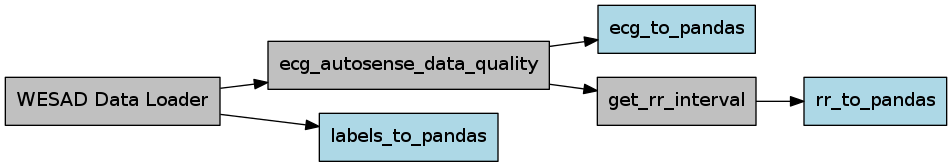

In [4]:
#Define data set properties
Fs         = 700
sensor     = "respiban"

#Define Workflow
dsd        = wesad_data_loader(data_size="small")
dfl        = cc_to_pandas(dsd,name="labels_to_pandas",key="labels",participant_field="user",datetime_field="timestamp",cache_filename="wesad_labels_small.pkl")
dsd        = ccwrapper(ecg_autosense_data_quality, dsd, sort_field="timestamp", sensor_name=sensor, Fs=Fs)
df_ecg     = cc_to_pandas(dsd,name="ecg_to_pandas",participant_field="user",datetime_field="timestamp",time_trunc=None,cache_filename="wesad_ecg_small.pkl")
dsd        = ccwrapper(get_rr_interval,dsd, sort_field="timestamp",Fs=Fs)
df_rr      = cc_to_pandas(dsd,name="rr_to_pandas",participant_field="user",datetime_field="timestamp",time_trunc=None,cache_filename="wesad_rr_small.pkl")

#Execute workflow
flow       = workflow({"ecg":df_ecg,"rr":df_rr,"labels":dfl});
output     = flow.run(backend="sequential", monitor=True, from_scratch=True);


## Display the results

In [5]:
display(output["ecg"]["dataframe"])

localtime       ecg  version  \
ID Time                                                                
s2 2017-05-22 02:15:00 2017-05-22 02:15:25.000000  0.021423        1   
   2017-05-22 02:15:00 2017-05-22 02:15:25.001429  0.020325        1   
   2017-05-22 02:15:00 2017-05-22 02:15:25.002857  0.016525        1   
   2017-05-22 02:15:00 2017-05-22 02:15:25.004286  0.016708        1   
   2017-05-22 02:15:00 2017-05-22 02:15:25.005714  0.011673        1   
...                                           ...       ...      ...   
   2017-05-22 03:56:00 2017-05-22 03:56:44.131994 -0.013138        1   
   2017-05-22 03:56:00 2017-05-22 03:56:44.133423 -0.010345        1   
   2017-05-22 03:56:00 2017-05-22 03:56:44.134851 -0.005447        1   
   2017-05-22 03:56:00 2017-05-22 03:56:44.136280  0.000137        1   
   2017-05-22 03:56:00 2017-05-22 03:56:44.137709  0.004074        1   

                           quality  
ID Time                             
s2 2017-05-22 02:15:00  acceptable  
   2017-05-22 02:15:00  acceptable  
   2017-05-22 02:15:00  acceptable  
   2017-05-22 02:15:00  acceptable  
   2017-05-22 02:15:00  acceptable  
...                            ...  
   2017-05-22 03:56:00  acceptable  
   2017-05-22 03:56:00  acceptable  
   2017-05-22 03:56:00  acceptable  
   2017-05-22 03:56:00  acceptable  
   2017-05-22 03:56:00  acceptable  

[4255300 rows x 4 columns]

In [6]:
display(output["rr"]["dataframe"])

localtime  version           rr
ID Time                                                                
s2 2017-05-22 02:15:00 2017-05-22 02:15:26.038595        1   730.016846
   2017-05-22 02:15:00 2017-05-22 02:15:26.764326        1   725.731201
   2017-05-22 02:15:00 2017-05-22 02:15:27.534344        1   770.017822
   2017-05-22 02:15:00 2017-05-22 02:15:28.467222        1   932.877930
   2017-05-22 02:15:00 2017-05-22 02:15:29.330099        1   862.877197
...                                           ...      ...          ...
   2017-05-22 03:56:00 2017-05-22 03:56:39.474745        1  1038.594971
   2017-05-22 03:56:00 2017-05-22 03:56:40.480482        1  1005.737061
   2017-05-22 03:56:00 2017-05-22 03:56:41.523363        1  1042.880859
   2017-05-22 03:56:00 2017-05-22 03:56:42.559101        1  1035.738037
   2017-05-22 03:56:00 2017-05-22 03:56:43.591982        1  1032.880859

[6879 rows x 3 columns]

In [7]:
display(output["labels"]["dataframe"])

target
ID Time                       
s2 2017-05-22 02:20:00       0
   2017-05-22 02:21:00       0
   2017-05-22 02:22:00       0
   2017-05-22 02:23:00       0
   2017-05-22 02:24:00       0
   2017-05-22 02:25:00       0
   2017-05-22 02:26:00       0
   2017-05-22 02:27:00       0
   2017-05-22 02:28:00       0
   2017-05-22 02:29:00       0
   2017-05-22 02:30:00       0
   2017-05-22 02:31:00       0
   2017-05-22 02:32:00       0
   2017-05-22 02:33:00       0
   2017-05-22 02:34:00       0
   2017-05-22 02:35:00       0
   2017-05-22 02:36:00       0
   2017-05-22 02:37:00       0
   2017-05-22 02:38:00       0
   2017-05-22 02:39:00       0
   2017-05-22 02:53:00       1
   2017-05-22 02:54:00       1
   2017-05-22 02:55:00       1
   2017-05-22 02:56:00       1
   2017-05-22 02:57:00       1
   2017-05-22 02:58:00       1
   2017-05-22 02:59:00       1
   2017-05-22 03:00:00       1
   2017-05-22 03:01:00       1
   2017-05-22 03:02:00       1
   2017-05-22 03:03:00       1
   2017-05-22 03:23:00       0
   2017-05-22 03:24:00       0
   2017-05-22 03:25:00       0
   2017-05-22 03:26:00       0
   2017-05-22 03:27:00       0
   2017-05-22 03:28:00       0
   2017-05-22 03:29:00       0
   2017-05-22 03:30:00       0
   2017-05-22 03:34:00       0
   2017-05-22 03:35:00       0
   2017-05-22 03:36:00       0
   2017-05-22 03:37:00       0
   2017-05-22 03:38:00       0
   2017-05-22 03:39:00       0
   2017-05-22 03:40:00       0
   2017-05-22 03:47:00       0
   2017-05-22 03:48:00       0
   2017-05-22 03:49:00       0
   2017-05-22 03:50:00       0
   2017-05-22 03:51:00       0
   2017-05-22 03:52:00       0
   2017-05-22 03:53:00       0